In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from cellpose import io
from liams_funcs import *
from features import *
from pytorch import *

import pandas as pd
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
control_dir = '../control_images/'
penetramax_dir = '../penetramax_images/'

control_fnames = [control_dir + fname for fname in os.listdir(control_dir)]
penetramax_fnames = [penetramax_dir + fname for fname in os.listdir(penetramax_dir)]

In [4]:
#ds = Dataset(control_fnames, penetramax_fnames)
#_ = ds.createImageDataset(final_size=224)

cell_data = LoadImageDataset('pytorch_dataset/cells/')
nucleus_data = LoadImageDataset('pytorch_dataset/nuclei/')

In [5]:
from torch.utils.data import DataLoader, random_split

train_data, val_data = random_split(nucleus_data, [0.8, 0.2])
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

In [6]:
net = Resnet18(train_layers=2)
net.to(device)
net.getSummary()

/Users/liam/Python/anaconda3/envs/AML_FP/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/liam/Python/anaconda3/envs/AML_FP/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [7]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

n_epochs = 1
loss_fn = CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=1e-3)

losses = []

for _ in range(n_epochs):
    for X, y in tqdm(train_dataloader):
        X.to(device)
        y_pred = net(X)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

  0%|          | 0/242 [00:00<?, ?it/s]

  5%|▌         | 13/242 [01:54<32:49,  8.60s/it]

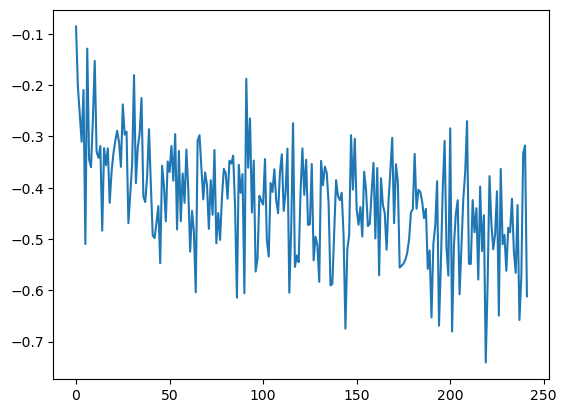

In [ ]:
plt.plot(np.log10(losses))

In [ ]:
from torchvision.models import resnet34

In [ ]:
rn = resnet34(pretrained=True)

/Users/liam/Python/anaconda3/envs/AML_FP/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for child in rn.children():
    print(child)
    print('\n')

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


ReLU(inplace=True)


MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [ ]:
import torch

class Resnet152(torch.nn.Module):
    def __init__(self, train_layers:int=10):
        super().__init__()
        from torchvision.models import resnet152

        rn = resnet152(pretrained=True)
        self.model = torch.nn.Sequential(
            rn,
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 2),
            torch.nn.Softmax()
        )

        for p in list(self.model.parameters())[-train_layers:]:
            p.requires_grad = False
    
    def forward(self, x):
        return self.model(x)
    
    def getSummary(self):
        from torchsummary import summary
        return summary(self, (3, 224, 224))

In [ ]:
net = Resnet152()
net.getSummary()

/Users/liam/Python/anaconda3/envs/AML_FP/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

/Users/liam/Python/anaconda3/envs/AML_FP/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
from torchsummary import summary
from torchvision.models import resnet152, resnet18, resnet34

rn = resnet34(pretrained=True)

summary(rn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,